In [2]:
!pip install lightning

In [3]:
!pip install transformers

In [4]:
!pip install torchmetrics

In [5]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel
import torchtext
import numpy as np
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
from torchmetrics import Accuracy, F1Score
import matplotlib.pyplot as plt

# util classes

In [6]:
class EmpathyTextDataset(Dataset):

    FILE_PATH = {'train': "/kaggle/input/empty-seeker-provider/train.csv",
                 'test': "/kaggle/input/empty-seeker-provider/test.csv",
                 'val': "/kaggle/input/empty-seeker-provider/val.csv",}

    def __init__(self, split="train", transforms=None):

        if split.lower() not in self.FILE_PATH.keys():
            raise Exception("must be train or test or val")

        df = pd.read_csv(self.FILE_PATH[split.lower()])
        self.x = df[['text']].to_numpy()
        self.y = df[['label']].to_numpy()
        self.n_sample = len(df)

        self.transforms = transforms

    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        return self._pipline_transforms(sample)
    
    def _pipline_transforms(self, sample):
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
        return sample
    
    def __len__(self):
        return self.n_sample

In [7]:
class TextCleaner:

    punc = '''!()-[]{.};:'"\,<>/?@#$%^&*_~`|’“”…—–'''

    def __call__(self, sample):
        text, target = sample
        text = text[0]
        text = text.lower()
        for each in self.punc:
            text = text.replace(each, ' ')
        return np.array([text]), target


class Tokenizer:

    def __init__(self, version="bert-base-uncased", max_len=128, tokenizer=None):
        self.tokenizer = AutoTokenizer.from_pretrained(version) if tokenizer is None else tokenizer
        self.MAX_LEN = max_len

    def __call__(self, sample):
        text, target = sample
        inputs = self.tokenizer.encode_plus(text[0], add_special_tokens=True, max_length=self.MAX_LEN, padding='max_length', 
                                             return_attention_mask=True, return_token_type_ids=True, truncation=True)
        return inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'], target


class ToTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        return tuple(torch.from_numpy(np.array(each)) for each in sample)
    

class OneHotLabel:
    
    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def __call__(self, sample):
        target = sample[-1]
        target = torch.squeeze(torch.nn.functional.one_hot(target, num_classes=self.num_classes), dim=0)
        sample = list(sample[:-1]) + [target]
        return tuple(sample)

In [8]:
class HistoryCallback(Callback):

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append({key: value.item() for key, value in trainer.callback_metrics.items()})

# bert

In [ ]:
train_dataset = EmpathyTextDataset(transforms=[TextCleaner(), Tokenizer(), ToTensor(), OneHotLabel(num_classes=3)])
test_dataset = EmpathyTextDataset(split="test", transforms=[TextCleaner(), Tokenizer(), ToTensor(), OneHotLabel(num_classes=3)])
val_dataset = EmpathyTextDataset(split="val", transforms=[TextCleaner(), Tokenizer(), ToTensor(), OneHotLabel(num_classes=3)])

In [ ]:
train_dataset[5]

In [ ]:
weights = torch.zeros(3)
for _, _, _, target in train_dataset:
    weights += target
weights

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)

In [ ]:
from transformers import BertConfig
configuration = BertConfig()
configuration

In [ ]:
class EmpathyKindBertModel(pl.LightningModule):
    
    num_classes = 3
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self):
        super().__init__()
        self.transformer_model = transformer_model=BertModel.from_pretrained("bert-base-uncased")
        self.bert_drop = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(768, self.num_classes)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask = mask, token_type_ids=token_type_ids)[1]
        x = self.bert_drop(x)
        output = self.out(x)
        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        # Logging to TensorBoard (if installed) by default
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [ ]:
print(EmpathyKindBertModel())

In [ ]:
model = EmpathyKindBertModel()

In [ ]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./bert",
    filename="bert-empathy-text-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=40, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

In [ ]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

In [ ]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

# Roberta

In [ ]:
from transformers import RobertaConfig
print(RobertaConfig())

In [9]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [10]:
train_dataset = EmpathyTextDataset(transforms=[TextCleaner(), 
                                               Tokenizer(tokenizer=tokenizer), 
                                               ToTensor(), 
                                               OneHotLabel(num_classes=3)])
test_dataset = EmpathyTextDataset(split="test", transforms=[TextCleaner(), 
                                                            Tokenizer(tokenizer=tokenizer), 
                                                            ToTensor(), 
                                                            OneHotLabel(num_classes=3)])
val_dataset = EmpathyTextDataset(split="val", transforms=[TextCleaner(), 
                                                          Tokenizer(tokenizer=tokenizer), 
                                                          ToTensor(), 
                                                          OneHotLabel(num_classes=3)])

In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)

In [12]:
from transformers import RobertaModel
class EmpathyKindRobertaModel(pl.LightningModule):
    
    num_classes = 3
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self):
        super().__init__()
        self.transformer_model = transformer_model=RobertaModel.from_pretrained("roberta-base")
        self.drop = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(768, self.num_classes)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask = mask, token_type_ids=token_type_ids)[0].mean(dim=1)
        x = self.drop(x)
        output = self.out(x)

        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        # Logging to TensorBoard (if installed) by default
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [13]:
model = EmpathyKindRobertaModel()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./roberta",
    filename="roberta-empathy-text-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=50, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type         | Params
---------------------------------------------------
0 | transformer_model | RobertaModel | 124 M 
1 | drop              | Dropout      | 0     
2 | out               | Linear       | 2.3 K 
---------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.592   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

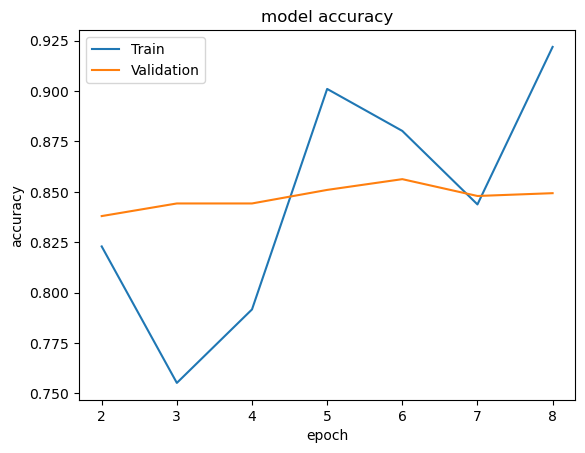

In [17]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

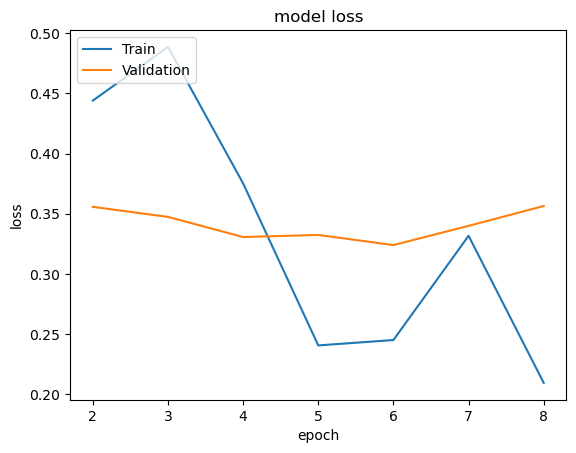

In [18]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [19]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /kaggle/working/roberta/roberta-empathy-text-epoch=05-val_loss=0.32.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from checkpoint at /kaggle/working/roberta/roberta-empathy-text-epoch=05-val_loss=0.32.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.8417866826057434     │
│       test_f1_epoch       │    0.7545834183692932     │
│      test_loss_epoch      │    0.3503056764602661     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.3503056764602661,
  'test_accuracy_epoch': 0.8417866826057434,
  'test_f1_epoch': 0.7545834183692932}]

# Albert

In [ ]:
from transformers import AlbertConfig
print(AlbertConfig())

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

In [ ]:
train_dataset = EmpathyTextDataset(transforms=[TextCleaner(), 
                                               Tokenizer(tokenizer=tokenizer), 
                                               ToTensor(), 
                                               OneHotLabel(num_classes=3)])
test_dataset = EmpathyTextDataset(split="test", transforms=[TextCleaner(), 
                                                            Tokenizer(tokenizer=tokenizer), 
                                                            ToTensor(), 
                                                            OneHotLabel(num_classes=3)])
val_dataset = EmpathyTextDataset(split="val", transforms=[TextCleaner(), 
                                                          Tokenizer(tokenizer=tokenizer), 
                                                          ToTensor(), 
                                                          OneHotLabel(num_classes=3)])

In [ ]:
train_dataset[8]

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)

In [ ]:
from transformers import AlbertModel
class EmpathyKindAlbertModel(pl.LightningModule):
    
    num_classes = 3
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self):
        super().__init__()
        self.transformer_model = transformer_model=AlbertModel.from_pretrained("albert-base-v2")
        self.drop = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(768, self.num_classes)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask = mask, token_type_ids=token_type_ids)[1]
        x = self.drop(x)
        output = self.out(x)

        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        # Logging to TensorBoard (if installed) by default
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [ ]:
model = EmpathyKindAlbertModel()

In [ ]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./albert",
    filename="albert-empathy-text-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=50, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

In [ ]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

In [ ]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

# XLNet

In [6]:
from transformers import XLNetConfig
print(XLNetConfig())

XLNetConfig {
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 4096,
  "d_model": 1024,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": 512,
  "model_type": "xlnet",
  "n_head": 16,
  "n_layer": 24,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "transformers_version": "4.26.1",
  "untie_r": true,
  "use_mems_eval": true,
  "use_mems_train": false,
  "vocab_size": 32000
}



In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

In [10]:
train_dataset = EmpathyTextDataset(transforms=[TextCleaner(), 
                                               Tokenizer(tokenizer=tokenizer), 
                                               ToTensor(), 
                                               OneHotLabel(num_classes=3)])
test_dataset = EmpathyTextDataset(split="test", transforms=[TextCleaner(), 
                                                            Tokenizer(tokenizer=tokenizer), 
                                                            ToTensor(), 
                                                            OneHotLabel(num_classes=3)])
val_dataset = EmpathyTextDataset(split="val", transforms=[TextCleaner(), 
                                                          Tokenizer(tokenizer=tokenizer), 
                                                          ToTensor(), 
                                                          OneHotLabel(num_classes=3)])

In [11]:
train_dataset[0]

(tensor([   5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
            5,    5,    5,    5,    5,    5,    5,    5,    5, 4553,   44,  172,
          178,   28,  172, 2763, 6793, 4278,    4,    3]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)

In [19]:
from transformers import XLNetModel
class EmpathyKindXLNetModel(pl.LightningModule):
    
    num_classes = 3
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self):
        super().__init__()
        self.transformer_model = transformer_model=XLNetModel.from_pretrained("xlnet-base-cased")
        self.drop = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(768, self.num_classes)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask = mask, token_type_ids=token_type_ids)[0].mean(dim=1)
        x = self.drop(x)
        output = self.out(x)
        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        # Logging to TensorBoard (if installed) by default
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [20]:
model = EmpathyKindXLNetModel()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./xlnet",
    filename="xlnet-empathy-text-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=50, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type       | Params
-------------------------------------------------
0 | transformer_model | XLNetModel | 116 M 
1 | drop              | Dropout    | 0     
2 | out               | Linear     | 2.3 K 
-------------------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
466.883   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 6it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

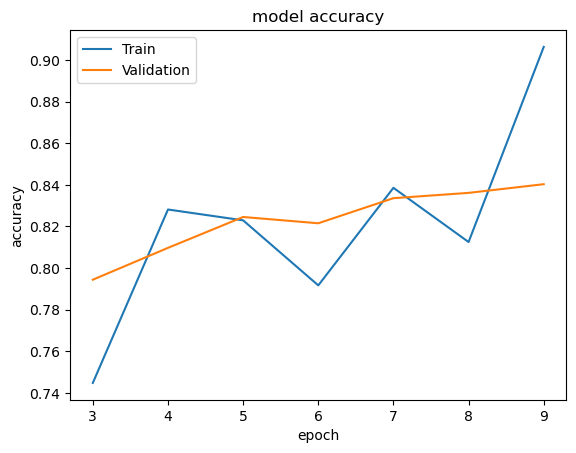

In [23]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

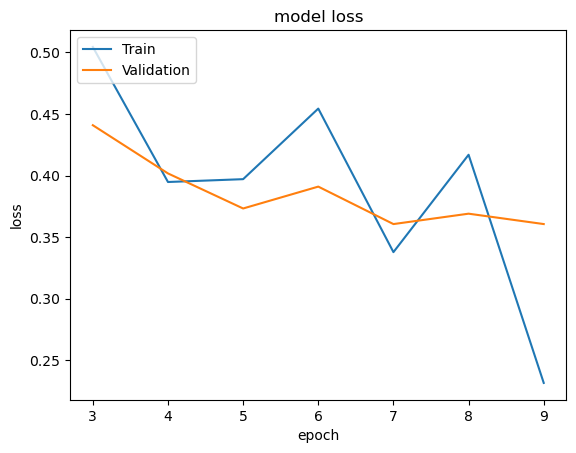

In [24]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [25]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /kaggle/working/xlnet/xlnet-empathy-text-epoch=05-val_loss=0.36.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from checkpoint at /kaggle/working/xlnet/xlnet-empathy-text-epoch=05-val_loss=0.36.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.8307242393493652     │
│       test_f1_epoch       │    0.7415220141410828     │
│      test_loss_epoch      │    0.38435816764831543    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.38435816764831543,
  'test_accuracy_epoch': 0.8307242393493652,
  'test_f1_epoch': 0.7415220141410828}]

# DistilBert

In [7]:
from transformers import DistilBertConfig
print(DistilBertConfig())

DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}



In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [9]:
train_dataset = EmpathyTextDataset(transforms=[TextCleaner(), 
                                               Tokenizer(tokenizer=tokenizer), 
                                               ToTensor(), 
                                               OneHotLabel(num_classes=3)])
test_dataset = EmpathyTextDataset(split="test", transforms=[TextCleaner(), 
                                                            Tokenizer(tokenizer=tokenizer), 
                                                            ToTensor(), 
                                                            OneHotLabel(num_classes=3)])
val_dataset = EmpathyTextDataset(split="val", transforms=[TextCleaner(), 
                                                          Tokenizer(tokenizer=tokenizer), 
                                                          ToTensor(), 
                                                          OneHotLabel(num_classes=3)])

In [15]:
train_dataset[0]

(tensor([  101,  4067,  2017,  2200,  2172,  2005,  2200,  6179, 12247,  5262,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [10]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)

In [19]:
from transformers import DistilBertModel


class EmpathyKindDistilBertModel(pl.LightningModule):
    
    num_classes = 3
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self):
        super().__init__()
        self.transformer_model = transformer_model=DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.drop = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(768, self.num_classes)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask=mask)[0].mean(dim=1)
        x = self.drop(x)
        output = self.out(x)

        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        # Logging to TensorBoard (if installed) by default
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [20]:
model = EmpathyKindDistilBertModel()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./distilbert",
    filename="distilbert-empathy-text-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=50, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type            | Params
------------------------------------------------------
0 | transformer_model | DistilBertModel | 66.4 M
1 | drop              | Dropout         | 0     
2 | out               | Linear          | 2.3 K 
------------------------------------------------------
66.4 M    Trainable params
0         Non-trainable params
66.4 M    Total params
265.461   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

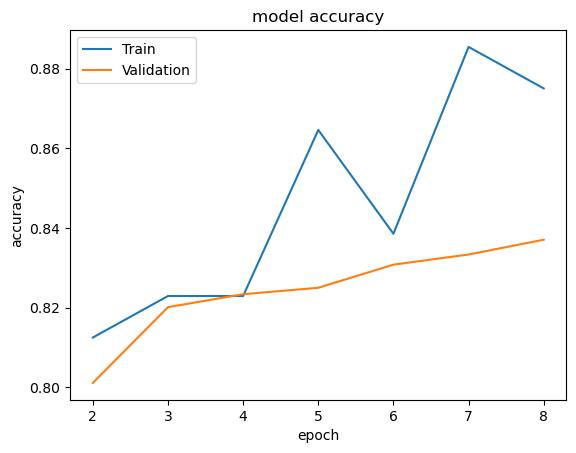

In [23]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

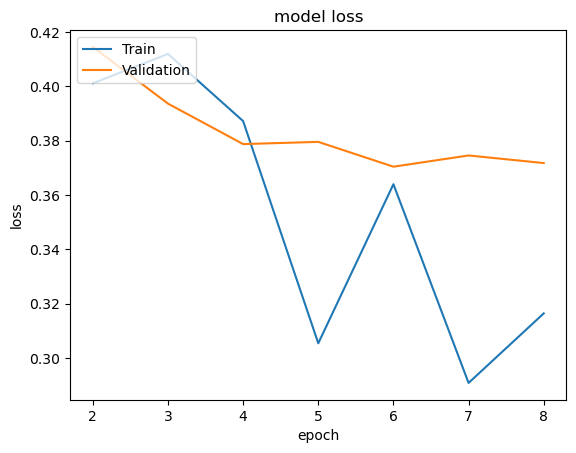

In [24]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [25]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /kaggle/working/distilbert/distilbert-empathy-text-epoch=05-val_loss=0.37.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from checkpoint at /kaggle/working/distilbert/distilbert-empathy-text-epoch=05-val_loss=0.37.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.8113128542900085     │
│       test_f1_epoch       │    0.7053790092468262     │
│      test_loss_epoch      │    0.4105127155780792     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.4105127155780792,
  'test_accuracy_epoch': 0.8113128542900085,
  'test_f1_epoch': 0.7053790092468262}]

# Electra

In [8]:
from transformers import ElectraConfig
print(ElectraConfig())

ElectraConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [1]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/electra-small-discriminator")

In [10]:
train_dataset = EmpathyTextDataset(transforms=[TextCleaner(), 
                                               Tokenizer(tokenizer=tokenizer), 
                                               ToTensor(), 
                                               OneHotLabel(num_classes=3)])
test_dataset = EmpathyTextDataset(split="test", transforms=[TextCleaner(), 
                                                            Tokenizer(tokenizer=tokenizer), 
                                                            ToTensor(), 
                                                            OneHotLabel(num_classes=3)])
val_dataset = EmpathyTextDataset(split="val", transforms=[TextCleaner(), 
                                                          Tokenizer(tokenizer=tokenizer), 
                                                          ToTensor(), 
                                                          OneHotLabel(num_classes=3)])

In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)

In [19]:
from transformers import ElectraModel
class EmpathyKindElectraModel(pl.LightningModule):
    
    num_classes = 3
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self):
        super().__init__()
        self.transformer_model = transformer_model=ElectraModel.from_pretrained("google/electra-small-discriminator")
        self.drop = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(256, self.num_classes)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask = mask, token_type_ids=token_type_ids)[0].mean(dim=1)
        x = self.drop(x)
        output = self.out(x)

        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        # Logging to TensorBoard (if installed) by default
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [20]:
model = EmpathyKindElectraModel()

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./electra",
    filename="electra-empathy-text-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=50, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type         | Params
---------------------------------------------------
0 | transformer_model | ElectraModel | 13.5 M
1 | drop              | Dropout      | 0     
2 | out               | Linear       | 771   
---------------------------------------------------
13.5 M    Trainable params
0         Non-trainable params
13.5 M    Total params
53.935    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

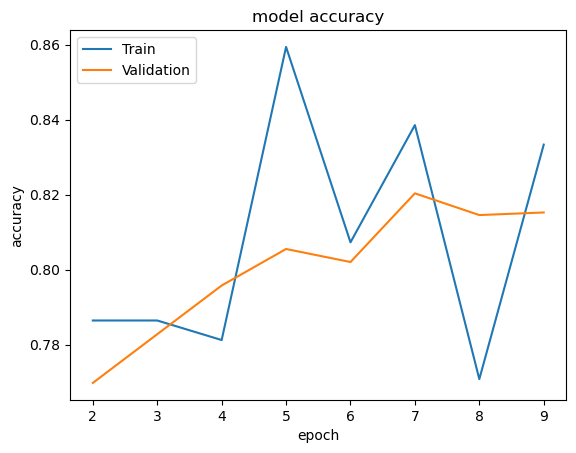

In [23]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

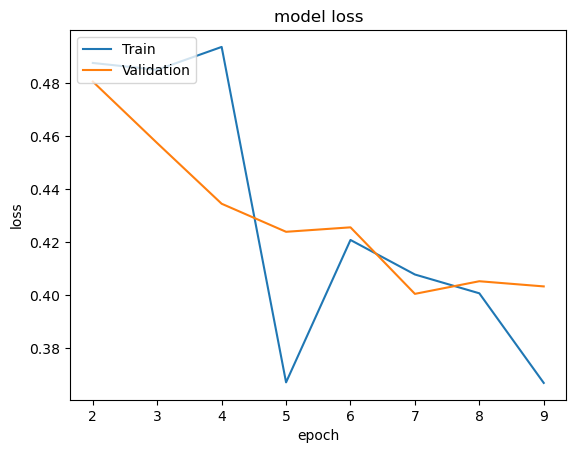

In [24]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [25]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /kaggle/working/electra/electra-empathy-text-epoch=06-val_loss=0.40.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from checkpoint at /kaggle/working/electra/electra-empathy-text-epoch=06-val_loss=0.40.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.8069297075271606     │
│       test_f1_epoch       │    0.7032459378242493     │
│      test_loss_epoch      │    0.42105787992477417    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.42105787992477417,
  'test_accuracy_epoch': 0.8069297075271606,
  'test_f1_epoch': 0.7032459378242493}]

# Deberta

In [9]:
from transformers import DebertaConfig
print(ElectraConfig())

ElectraConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

In [12]:
train_dataset = EmpathyTextDataset(transforms=[TextCleaner(), 
                                               Tokenizer(tokenizer=tokenizer), 
                                               ToTensor(), 
                                               OneHotLabel(num_classes=3)])
test_dataset = EmpathyTextDataset(split="test", transforms=[TextCleaner(), 
                                                            Tokenizer(tokenizer=tokenizer), 
                                                            ToTensor(), 
                                                            OneHotLabel(num_classes=3)])
val_dataset = EmpathyTextDataset(split="val", transforms=[TextCleaner(), 
                                                          Tokenizer(tokenizer=tokenizer), 
                                                          ToTensor(), 
                                                          OneHotLabel(num_classes=3)])

In [13]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)

In [18]:
from transformers import DebertaModel


class EmpathyKindDebertaModel(pl.LightningModule):
    
    num_classes = 3
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="multilabel", num_labels=3).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self):
        super().__init__()
        self.transformer_model = transformer_model=DebertaModel.from_pretrained("microsoft/deberta-base")
        self.drop = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(768, self.num_classes)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask = mask, token_type_ids=token_type_ids)[0].mean(dim=1)
        x = self.drop(x)
        output = self.out(x)

        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        # Logging to TensorBoard (if installed) by default
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [19]:
model = EmpathyKindDebertaModel()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./deberta",
    filename="deberta-empathy-text-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=50, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type         | Params
---------------------------------------------------
0 | transformer_model | DebertaModel | 138 M 
1 | drop              | Dropout      | 0     
2 | out               | Linear       | 2.3 K 
---------------------------------------------------
138 M     Trainable params
0         Non-trainable params
138 M     Total params
554.416   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

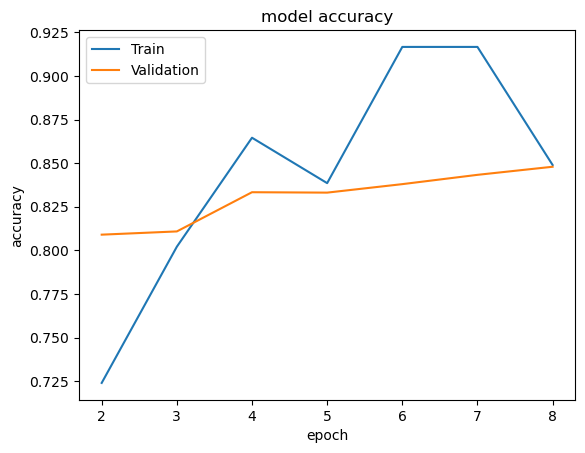

In [23]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

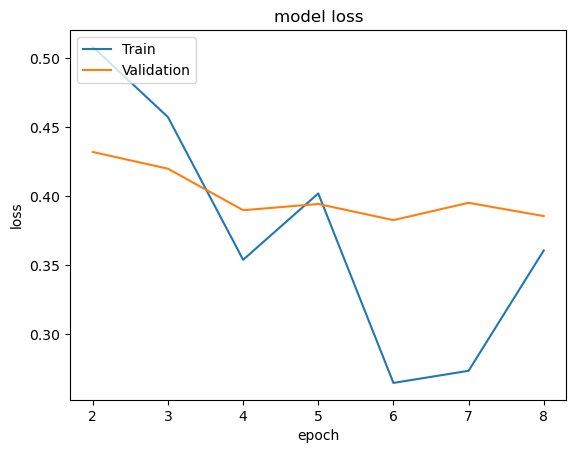

In [24]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [25]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /kaggle/working/deberta/deberta-empathy-text-epoch=05-val_loss=0.38.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from checkpoint at /kaggle/working/deberta/deberta-empathy-text-epoch=05-val_loss=0.38.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.8359423875808716     │
│       test_f1_epoch       │    0.7347941994667053     │
│      test_loss_epoch      │    0.38665762543678284    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.38665762543678284,
  'test_accuracy_epoch': 0.8359423875808716,
  'test_f1_epoch': 0.7347941994667053}]